In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install geopandas rasterio shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.5 MB/s eta 0:00:00


In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window
import os
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import box
from rasterio.features import shapes
from shapely.geometry import shape

In [4]:
# Ruta del archivo original
input_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/data/cropped_image_1.tif'

# Nueva ruta de salida: dentro de "output/tiles/"
output_folder = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/tiles'
os.makedirs(output_folder, exist_ok=True)

In [5]:
# Abrir imagen
with rasterio.open(input_path) as src:
    img = src.read()  # (bands, height, width)
    profile = src.profile
    transform = src.transform
    resolution = src.res

# Imprimir resolución espacial
print("Resolución (tamaño de pixel):", resolution)

Resolución (tamaño de pixel): (8.983152841195215e-05, 8.983152841195215e-05)


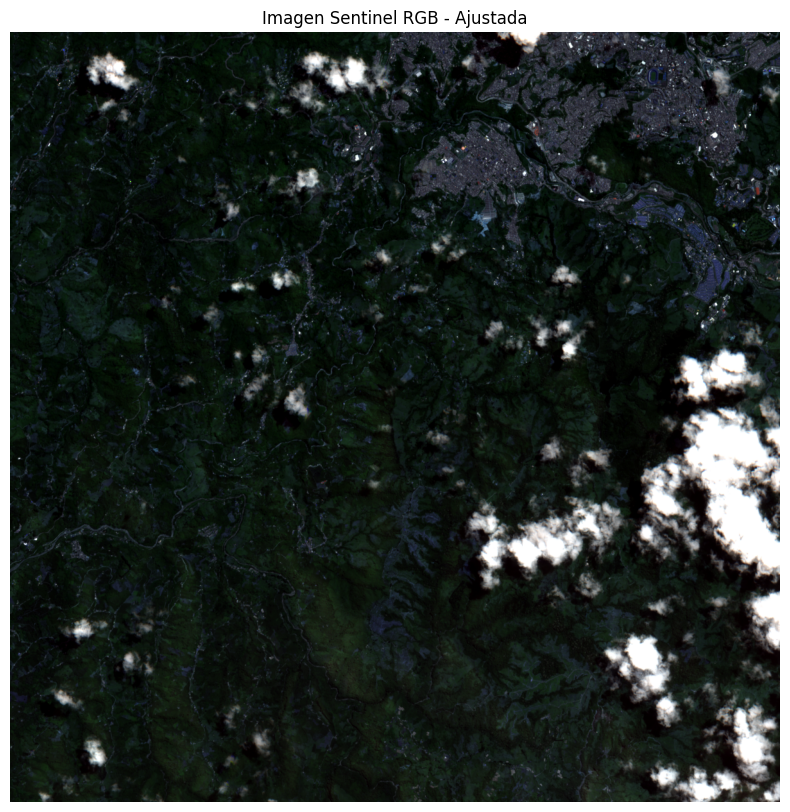

In [6]:
# Normalizar manualmente usando percentiles para mejor contraste
def stretch_band(band, min_percent=2, max_percent=98):
    min_val = np.percentile(band, min_percent)
    max_val = np.percentile(band, max_percent)
    stretched = np.clip((band - min_val) / (max_val - min_val), 0, 1)
    return stretched

# Aplicar stretch a cada banda
r_stretch = stretch_band(img[0])
g_stretch = stretch_band(img[1])
b_stretch = stretch_band(img[2])

rgb_stretch = np.stack([r_stretch, g_stretch, b_stretch], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb_stretch)
plt.title("Imagen Sentinel RGB - Ajustada")
plt.axis('off')
plt.show()


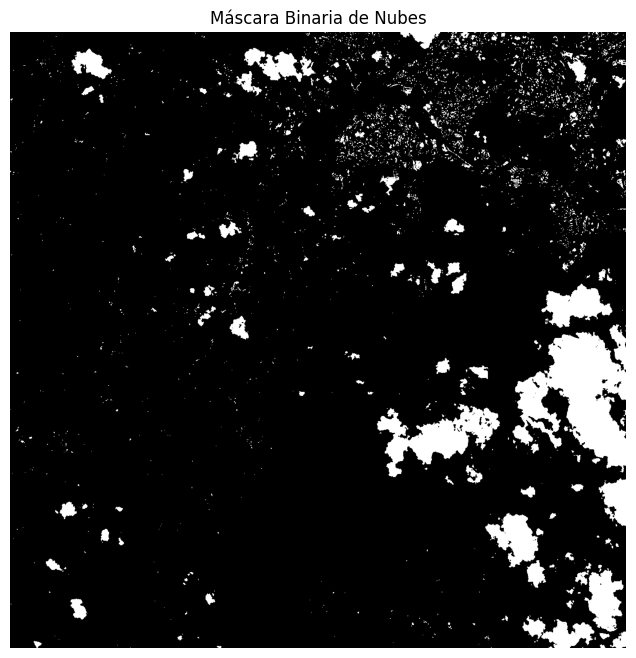

✅ GeoJSON y Shapefile exportados:
GeoJSON: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/nube_mask.geojson
SHP: /content/drive/MyDrive/2.TRABAJOS/INTEIA/output/nube_mask.shp


In [11]:
# Rutas
img_path = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/data/cropped_image_1.tif'
output_folder = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output'

# Leer imagen
with rasterio.open(img_path) as src:
    img = src.read([1, 2, 3])  # RGB
    transform = src.transform
    crs = src.crs

# Normalización
r = img[0].astype(np.float32) / img[0].max()
g = img[1].astype(np.float32) / img[1].max()
b = img[2].astype(np.float32) / img[2].max()

# Crear máscara de nubes (ajustable)
nube_mask = ((r > 0.1) & (g > 0.1) & (b > 0.1)).astype(np.uint8)

# Visualización rápida
plt.figure(figsize=(8, 8))
plt.imshow(nube_mask, cmap='gray')
plt.title("Máscara Binaria de Nubes")
plt.axis('off')
plt.show()

# Convertir máscara a vectores (polígonos)
results = (
    {'properties': {'class': 'nube'}, 'geometry': s}
    for s, v in shapes(nube_mask, mask=nube_mask.astype(bool), transform=transform)
)

geoms = list(results)
gdf = gpd.GeoDataFrame.from_features(geoms, crs=crs)

# Exportar como GeoJSON
geojson_path = os.path.join(output_folder, 'nube_mask.geojson')
gdf.to_file(geojson_path, driver='GeoJSON')

# Exportar como Shapefile
shp_path = os.path.join(output_folder, 'nube_mask.shp')
gdf.to_file(shp_path)

print("✅ GeoJSON y Shapefile exportados:")
print("GeoJSON:", geojson_path)
print("SHP:", shp_path)


In [ ]:
# Tamaño del tile (en píxeles)
tile_size = 120
tile_index = 0  # contador para nombres secuenciales

with rasterio.open(input_path) as src:
    width = src.width
    height = src.height
    meta = src.meta.copy()

    for i in tqdm(range(0, height, tile_size)):
        for j in range(0, width, tile_size):
            if i + tile_size <= height and j + tile_size <= width:
                window = Window(j, i, tile_size, tile_size)
                transform = src.window_transform(window)
                tile = src.read(window=window)

                meta_tile = meta.copy()
                meta_tile.update({
                    'height': tile.shape[1],
                    'width': tile.shape[2],
                    'transform': transform
                })

                tile_filename = f'tile_{tile_index}.tif'
                tile_path = os.path.join(output_folder, tile_filename)

                with rasterio.open(tile_path, 'w', **meta_tile) as dst:
                    dst.write(tile)

                tile_index += 1  # aumentar el contador

print("✅ Todos los tiles han sido exportados con nombres secuenciales.")

100%|██████████| 10/10 [00:01<00:00,  5.66it/s]

✅ Todos los tiles han sido exportados con nombres secuenciales.


In [ ]:
# Carpetas de salida
output_shp = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/tiles_index.shp'
output_geojson = '/content/drive/MyDrive/2.TRABAJOS/INTEIA/output/tiles_index.geojson'

# Lista para almacenar geometrías e IDs
geoms = []

with rasterio.open(input_path) as src:
    transform = src.transform
    crs = src.crs
    width = src.width
    height = src.height

    tile_size = 120
    tile_index = 0

    for i in range(0, height, tile_size):
        for j in range(0, width, tile_size):
            if i + tile_size <= height and j + tile_size <= width:
                x_min, y_min = transform * (j, i + tile_size)
                x_max, y_max = transform * (j + tile_size, i)
                geom = box(x_min, y_min, x_max, y_max)
                geoms.append({'geometry': geom, 'tile_id': tile_index})
                tile_index += 1

# Crear GeoDataFrame
gdf = gpd.GeoDataFrame(geoms, crs=crs)

# Guardar shapefile
gdf.to_file(output_shp)
# Guardar GeoJSON
gdf.to_file(output_geojson, driver='GeoJSON')

print("✅ Shapefile y GeoJSON guardados correctamente.")


✅ Shapefile y GeoJSON guardados correctamente.


PREPARAR LOS DATOS PARA ENTRENAR EN unet